<a href="https://colab.research.google.com/github/lucansdev/bairesDev/blob/main/aula_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

#MANIPULAÇÃO DA BASE DE DADOS

Nesta célula de código, baixei, extraí e limpei as imagens para deixar a base de dados em perfeitas condições para o treinamento da IA sem problemas.


In [23]:
import os
import shutil
import zipfile
import requests
from PIL import Image


def baixar_base(url, output_path):
    response = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(response.content)

def extrair(arquivo_zip, extract_to):
    with zipfile.ZipFile(arquivo_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


def limpar_imagens_e_limitar(base_pets, categorias, limit):
    for category in categories:
        category_path = os.path.join(base_pets, category)
        images = os.listdir(category_path)
        valid_images = []

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()
                valid_images.append(img_name)
            except (IOError, SyntaxError):
                os.remove(img_path)


        for img_name in valid_images[limit:]:
            os.remove(os.path.join(category_path, img_name))


url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
arquivo_zip = "kagglecatsanddogs_5340.zip"
base_pets = "/content/cats_vs_dogs/PetImages"
categorias = ["Cat", "Dog"]
limit = 200

baixar_base(url, arquivo_zip)

extrair(arquivo_zip, "/content/cats_vs_dogs")

limpar_imagens_e_limitar(base_pets, categorias, limit)

for category in categorias:
    print(f"{category}: {len(os.listdir(os.path.join(base_pets, category)))} imagens")

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Cat: 200 imagens
Dog: 200 imagens


In [24]:
root = '/content/cats_vs_dogs/PetImages'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/content/cats_vs_dogs/PetImages/Dog', '/content/cats_vs_dogs/PetImages/Cat']


Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada

In [25]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz

In [26]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Embaralhe a ordem dos dados

In [27]:
random.shuffle(data)

Criar conjuntos de dados para treino, validação e teste, com uma divisão de 70%, 15% e 15%, respectivamente.

In [28]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separe os dados por rótulos

In [29]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


Pré-processe os dados como antes, certificando-se de que estejam no formato float32 e normalizados entre 0 e 1

In [30]:
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(60, 2)


Aqui temos algumas imagens de nosso dateset

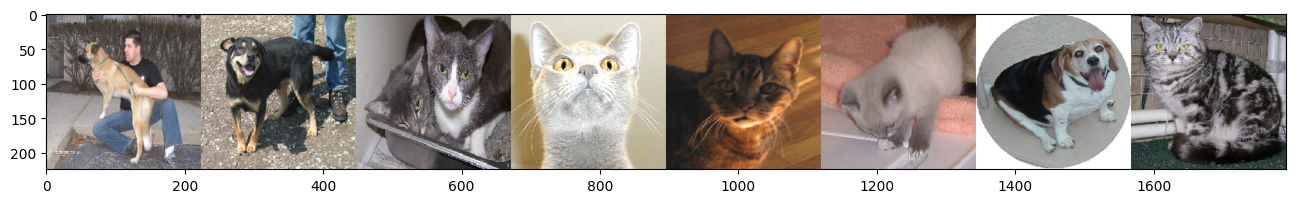

In [31]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

**Primeiro treinando uma rede neural do zero**

Aqui nos vamos implementar uma rede neural do zero.

Após compilar a rede, vamos executar model.summary() para obter um resumo de suas camadas.

In [32]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Agora podemos prosseguir e treinar nosso modelo por 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo mais tarde.

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.5263 - loss: 0.7102 - val_accuracy: 0.5167 - val_loss: 0.6835
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.5091 - loss: 0.6868 - val_accuracy: 0.4833 - val_loss: 0.6978
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.5385 - loss: 0.6905 - val_accuracy: 0.4833 - val_loss: 0.6964
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.5376 - loss: 0.6853 - val_accuracy: 0.5167 - val_loss: 0.6879
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.5891 - loss: 0.6775 - val_accuracy: 0.6333 - val_loss: 0.6774
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.6255 - loss: 0.6756 - val_accuracy: 0.7333 - val_loss: 0.6556
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.6686 - loss: 0.6527 - val_accuracy: 0.5833 - val_loss: 0.6485
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.6697 - loss: 0.6476 - val_accuracy: 0.7167 - val_loss: 0.6099
Epoch 9/

Vamos plotar a perda de validação e a acurácia de validação ao longo do tempo

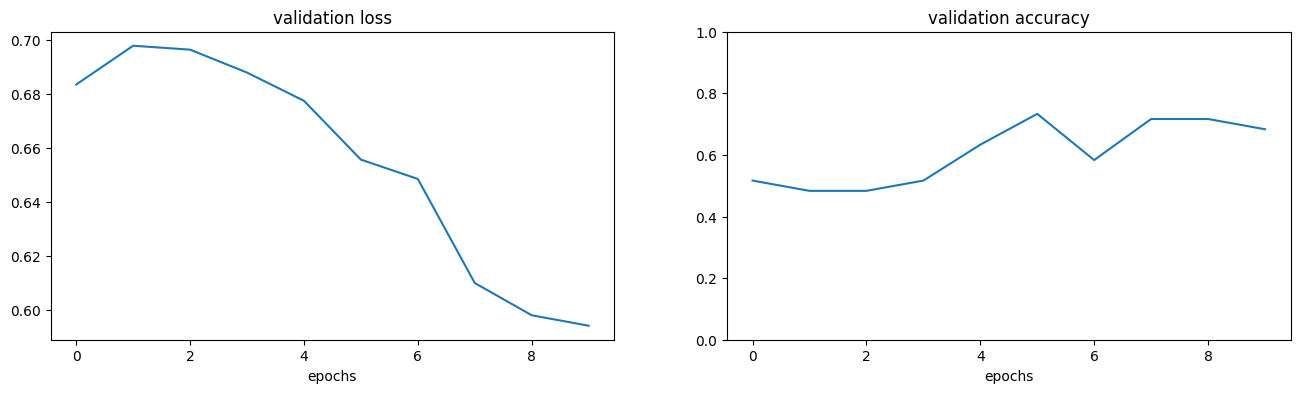

In [36]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history['val_accuracy'])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Ao fazer isso, obtemos os seguintes resultados:

In [37]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6419441103935242
Test accuracy: 0.5666666626930237


#Transferência de aprendizado começando com uma rede existente

Para começar, vamos carregar o VGG16 do Keras, que foi treinado no ImageNet e teve seus pesos salvos online. Se esta é a sua primeira vez carregando o VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Uma vez que a rede esteja carregada, podemos inspecionar as camadas novamente com o método summary()

In [38]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Aqui nos vamos copiar a VGG da primeira camada ate a penultima camada para trabalhar com ela, e uma forma mais facil de implementação numa IA ja treinada.

In [39]:
inp = vgg.input

new_classification_layer = Dense(num_classes, activation='softmax')

out = new_classification_layer(vgg.layers[-2].output)

model_new = Model(inp, out)

Então, vamos em frente e congelamos as camadas e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda que em nossa primeira rede, para fins de uma comparação justa. Em seguida, executamos o summary novamente para observar a arquitetura da rede

In [40]:
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Como antes, prossiga e treine o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também acompanhe seu histórico à medida que avançamos

In [41]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 231s 73s/step - accuracy: 0.4546 - loss: 1.1223 - val_accuracy: 0.5000 - val_loss: 0.7119
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 252s 69s/step - accuracy: 0.5946 - loss: 0.7156 - val_accuracy: 0.5333 - val_loss: 0.6937
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 223s 69s/step - accuracy: 0.5118 - loss: 0.6995 - val_accuracy: 0.5000 - val_loss: 0.8045
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 266s 69s/step - accuracy: 0.5835 - loss: 0.6691 - val_accuracy: 0.5667 - val_loss: 0.6255
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 220s 69s/step - accuracy: 0.5314 - loss: 0.6371 - val_accuracy: 0.8167 - val_loss: 0.5586
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 267s 72s/step - accuracy: 0.7321 - loss: 0.5601 - val_accuracy: 0.5500 - val_loss: 0.7023
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 258s 69s/step - accuracy: 0.6432 - loss: 0.6127 - val_accuracy: 0.8167 - val_loss: 0.5062
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 215s 67s/step - accuracy: 0.8137 - loss: 0.5014 - val_accuracy: 0.7500 - val_loss:

Vamos plotar a perda de validação e a acurácia novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo com transferência de aprendizado (em verde)

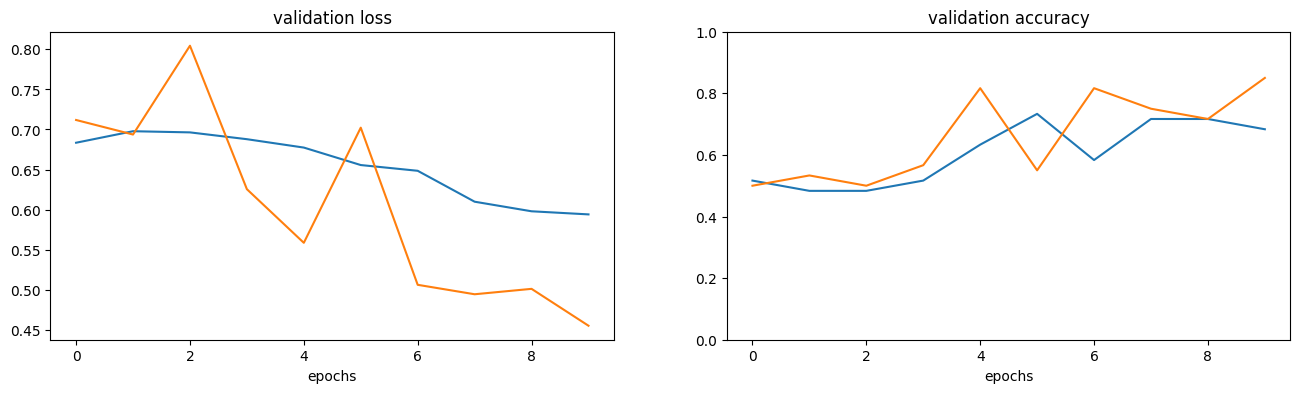

In [44]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history['val_accuracy'])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [45]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.415706068277359
Test accuracy: 0.8333333134651184


Para prever uma nova imagem, basta executar o seguinte código para obter as probabilidades para cada classe.

In [49]:
img, x = get_image("/content/cats_vs_dogs/PetImages/Cat/10016.jpg")
probabilities = model_new.predict([x])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
